# Continual Learning 
## Introduction and fundamental techniques
Authors: Mateusz Wójcik, Mateusz Stolarski  
Contact: mateusz.wojcik@pwr.edu.pl

This notebook contains introduction into Continual Learning in form of a interactive hands-on playground. The aim was to provide a Python environment where You will be able to dive into the Continual Learning world by preparing and running some practical experiments. We have prepared ready to run experimental setups covering various Continual Learning scenarios.

Don't hesitate to make some mess by chaning setups, models, scenarios, methods and other.

Good luck!

***

# What is Continual Learning?

Continual Learning studies the problem of learning from an infinite stream of data, with the goal of gradually extending acquired knowledge and using it for future learning [1]. So in a Continual Learning scenario:
- we don't have all of the data at the same time
- model is trained on the stream of data
- data domain may change
- class set may change (in the classification problems)

Across the scientific literature, Continual Learning is also called: Incremental Learning, Sequential Learning, Continuous Learning and Lifelong Learning.

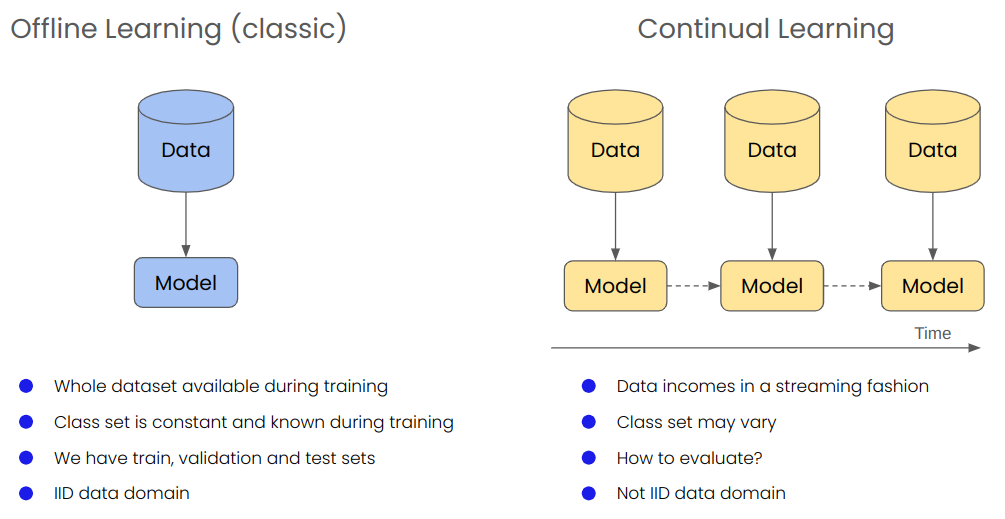

# Setup

To ensure a quality and reproducibility of experiments we have used the Avalanche [2]. Avalanche is a modern, rich featured Continual Learning library which takes take about a lot of bolierplate code, provides access to many useful datasets and delivers implementation of common Continual Learning methods.

You can find more information in the [Avalanche Github](https://github.com/ContinualAI/avalanche "Avalanche Github")

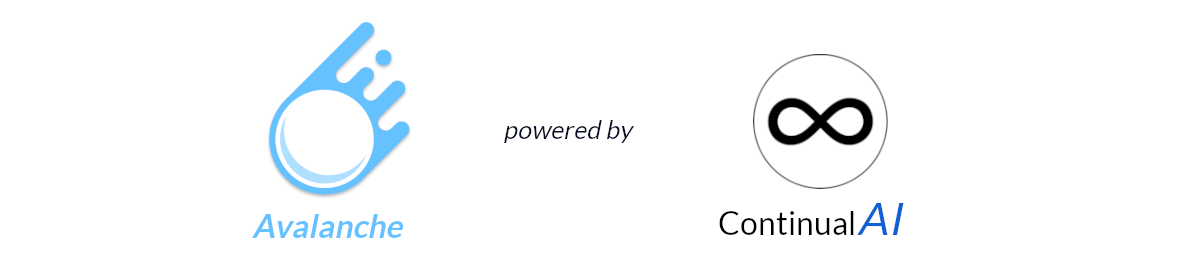

In [ ]:
from pprint import pprint

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from avalanche.benchmarks import SplitMNIST, PermutedMNIST, RotatedMNIST, ni_benchmark
from avalanche.benchmarks.datasets import MNIST
from avalanche.evaluation.metrics import forgetting_metrics, accuracy_metrics, loss_metrics
from avalanche.logging import InteractiveLogger
from avalanche.models import SimpleMLP
from avalanche.training.supervised import EWC, GEM, Naive, JointTraining, Replay
from avalanche.training.plugins import EvaluationPlugin
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchmetrics import Accuracy

In [ ]:
DATA_PATH = './tmp/'
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
BATCH_SIZE_TRAIN = 64
BATCH_SIZE_TEST = 256
SEED = 1

TEST_ACCURACY = 'Top1_Acc_Stream/eval_phase/test_stream/Task000'
DEFAULT_EVALUATOR = EvaluationPlugin(
    accuracy_metrics(
        minibatch=False, epoch=False, experience=True, stream=True
    ),
    loss_metrics(minibatch=False, epoch=False, experience=True, stream=True),
    loggers=[InteractiveLogger()],
)
NO_LOGGING_EVALUATOR = EvaluationPlugin(
    accuracy_metrics(
        minibatch=False, epoch=False, experience=True, stream=True
    ),
    loss_metrics(minibatch=False, epoch=False, experience=True, stream=True),
    loggers=[],
)

torch.manual_seed(SEED)

DEVICE

## Model

To not make thing overly complicated at the beggining, we prepared simple neural network (we called it MLP to keep namespace clear). The priority is to make training easy and quick, so we will be able to perform more experiments.

Keep in mind, that You are welcome with modyfying this architecture by changing/adding layers, modifying activation functions and experimenting with the dropout hyperparameter. But for the first notebook pass we suggest to keep this model intact.

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_layer_size: int = 784, hidden_layer_size: int = 256, output_layer_size: int = 10, drop_rate: float = 0.5) -> None:
        super().__init__()
        self._input_layer_size = input_layer_size
        self._layers = nn.Sequential(
            nn.Linear(
                in_features=input_layer_size,
                out_features=hidden_layer_size,
            ),
            nn.ReLU(),
            nn.Dropout(p=drop_rate),
            nn.Linear(
                in_features=hidden_layer_size,
                out_features=output_layer_size,
            ),
            nn.Softmax(dim=1)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x.contiguous()
        x = x.view(x.size(0), self._input_layer_size)
        return self._layers(x)

# Offline learning (classic)

Offline learning is the classic procedure that probably everybody has in mind when hear "model training". All the data is available at once, we have train (+ validation) and test sets and after training is finished, no chages are made in model parameters.

Let's train defined model in the offline regime.

## Offline training using Pytorch

Firstly, we will train a model using standard procedure in Pytorch library.

### Dataset

We will use MNIST dataset to make training and evaluation quick and smooth. It is well known and the most often used in the Continual Learning literature.

In [ ]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)),
    ]
)

mnist_train = datasets.MNIST(
    root=DATA_PATH,
    train=True,
    download=True,
    transform=transform,
)

mnist_test = datasets.MNIST(
    root=DATA_PATH,
    train=False,
    download=True,
    transform=transform,
)

train_loader = DataLoader(
    dataset=mnist_train,
    batch_size=BATCH_SIZE_TRAIN,
    shuffle=True,
)

test_loader = DataLoader(
    dataset=mnist_test,
    batch_size=BATCH_SIZE_TEST,
    shuffle=True,
)

### Train & test loops

Just a standard code.

In [ ]:
def train(model: nn.Module, train_loader: DataLoader, epoch: int, optimizer: torch.optim.Optimizer) -> None:
    loss = CrossEntropyLoss()
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(DEVICE), target.to(DEVICE)
        optimizer.zero_grad()
        output = model(data)
        train_loss = loss(output, target)
        train_loss.backward()
        optimizer.step()

        if batch_idx % 250 == 0:
          print(
            f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {train_loss.item():.6f}'
          )

def test(model: nn.Module, test_loader: DataLoader) -> None:
    loss = CrossEntropyLoss()
    model.eval()
    test_loss = 0
    
    preds = torch.tensor([]).to(DEVICE)
    expected = torch.tensor([]).to(DEVICE)

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            output = model(data)
            test_loss += loss(output, target)
            
            pred = output.max(1)[1]
            preds = torch.cat((preds, pred))
            expected = torch.cat((expected, target))
    
    test_loss /= len(test_loader.dataset)
    acc = Accuracy(task="multiclass", num_classes=10).to(DEVICE)
    
    print(f'Test Accuracy: {acc(preds, expected).item():.2f}')

### Training & Evaluation

Here is the experiment running code. Let's run the cell below and check what accuracy we will achieve.

In [ ]:
LEARNING_RATE = 0.001
TRAIN_EPOCHS = 3
INPUT_LAYER_SIZE = 784
HIDDEN_LAYER_SIZE = 256
OUTPUT_LAYER_SIZE = 10
DROP_RATE = 0.5

model = MLP(input_layer_size=INPUT_LAYER_SIZE, hidden_layer_size=HIDDEN_LAYER_SIZE, output_layer_size=OUTPUT_LAYER_SIZE, drop_rate=DROP_RATE).to(DEVICE)
optimizer = Adam(params=model.parameters(), lr=LEARNING_RATE)

for epoch in range(TRAIN_EPOCHS):
    train(epoch=epoch, model=model, train_loader=train_loader, optimizer=optimizer)
    test(model=model, test_loader=test_loader)

## Offline training using Avalanche

Was the code above a little bit complicated, wasn't it? 

Classic training procedure still has a lot of boilerplate code that can be "hidden". We can use Pytorch Lightning to create nice looking training code, but we can also use Avalanche library to perform classic, offline training. Let's do the same as in the "Offline training" section, but using the Avalanche library.

In [ ]:
# Setup
LEARNING_RATE = 0.001
TRAIN_EPOCHS = 3
DROP_RATE = 0.5
INPUT_LAYER_SIZE = 784
HIDDEN_LAYER_SIZE = 256
OUTPUT_LAYER_SIZE = 10

# Model.
# To make experiments fair, remember to always initialize a new model and not to use already trained one.
model = MLP(input_layer_size=INPUT_LAYER_SIZE, hidden_layer_size=HIDDEN_LAYER_SIZE, output_layer_size=OUTPUT_LAYER_SIZE, drop_rate=DROP_RATE)

# Dataset
mnist = SplitMNIST(n_experiences=1)
train_stream = mnist.train_stream
test_stream = mnist.test_stream

# Prepare for training & testing
optimizer = Adam(model.parameters(), lr=LEARNING_RATE)
criterion = CrossEntropyLoss()

# Joint training strategy
joint_train = JointTraining(
    model,
    optimizer,
    criterion,
    train_epochs=TRAIN_EPOCHS,
    train_mb_size=BATCH_SIZE_TRAIN,
    eval_mb_size=BATCH_SIZE_TEST,
    device=DEVICE,
    evaluator=DEFAULT_EVALUATOR,
)

# Train and test
results = []
joint_train.train(train_stream)
evaluation_result = joint_train.eval(test_stream)
results.append(evaluation_result)

pprint(evaluation_result)
print(f"Final accuracy: {evaluation_result[TEST_ACCURACY] * 100:.2f}%")

We were able to achieve similar accuracy by writing less code and simplify training procedure. Metric that is our iterest is 'Top1_Acc_Stream/eval_phase/test_stream/Task000', which means just an Accurracy over all classes. Why such a complicated name?
- **Top1_Acc_Stream** - we calculate Accuracy in the most common Top 1 setup (the most probable class only) and it is the overall result on the whole data in the test stream (test dataset)
- **eval_phase/test_stream** - evaluation performed on the test stream
- **Task000** - identifies the task, since here we have just one task this is quite redundant. But it's necessary when we have more that one task (e.g. Task Incremental Scenario).

For the further experiments we also need metric in the unified format to make its comparison and visualization easier.

# Incremental Learning

An important hyperparameter here is "N_EXPERIENCES" (n_experiences). It defined on how many "portions" the data will be divided and can be any positive number lower that train sieze. For example
- 1 means all the data will be available at once
- 10 means data will be splitted into 10 parts
- len(train_size) would mean each incoming portion of data contains only one example

## Naive approach

The simplest Continual Learning approach is to train model incrementally in the same way as we would train offline. The "Naive" approach assumes training the model on every incoming data batch without any additional actions. So we choose hyperparameters fo the model and train on first batch, then on the second batch and so on and so forth.

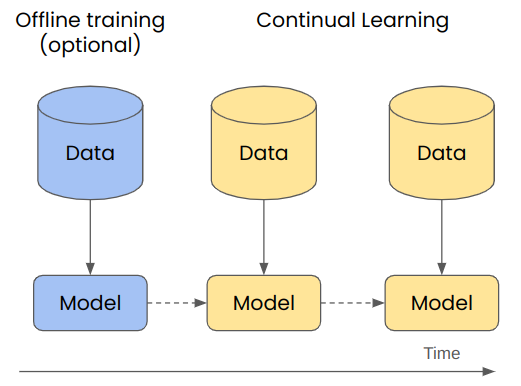

In [ ]:
# Setup
LEARNING_RATE = 0.001
TRAIN_EPOCHS = 1
DROP_RATE = 0.5
INPUT_LAYER_SIZE = 784
HIDDEN_LAYER_SIZE = 256
OUTPUT_LAYER_SIZE = 10 

# Model
# To make experiments fair, remember to always initialize a new model and not to use already trained one.
model = MLP(input_layer_size=INPUT_LAYER_SIZE, hidden_layer_size=HIDDEN_LAYER_SIZE, output_layer_size=OUTPUT_LAYER_SIZE, drop_rate=DROP_RATE)

def train_incremental(n_experiences: int, evaluator: EvaluationPlugin = DEFAULT_EVALUATOR) -> list[dict[str, float]]:
    # Dataset
    mnist = ni_benchmark(
        mnist_train,
        mnist_test,
        n_experiences=n_experiences,
        shuffle=True,
        seed=SEED,
        balance_experiences=True
    )
    
    train_stream = mnist.train_stream
    test_stream = mnist.test_stream
    
    # Prepare for training & testing
    optimizer = Adam(model.parameters(), lr=LEARNING_RATE)
    criterion = CrossEntropyLoss()
    
    # Joint training strategy
    naive_train = Naive(
        model,
        optimizer,
        criterion,
        train_epochs=TRAIN_EPOCHS,
        train_mb_size=BATCH_SIZE_TRAIN,
        eval_mb_size=BATCH_SIZE_TEST,
        device=DEVICE,
        evaluator=evaluator,
    )
    
    # Train and test
    results = []
    naive_train.train(train_stream)
    evaluation_result = naive_train.eval(test_stream)
    results.append(evaluation_result)

    return results

In [ ]:
# Setup
N_EXPERIENCES = 10 

evaluation_result = train_incremental(n_experiences=N_EXPERIENCES)

pprint(evaluation_result)
print(f"Final accuracy: {evaluation_result[-1][TEST_ACCURACY] * 100:.2f}%")

Wow, almost as good as offline training. Why it works so well?

The resaon behind it is that all the training batches have (in average) **data from the same domain**. So this incremental procedure is equal to classic (offline) training with train_epochs=1, because we we set TRAIN_EPOCHS hyperparameter which makes trainer to perform one pass over the data. So even we train the model incrementally, it is completely fine until all batches have similarly distributed data.

***

## Excercise 1 (10 min)

How **n_experiences** (number of experience) influences the final accuracy? Check different setups, especially:
- 1
- 10
- and some large number close to train dataset size

In [ ]:
N_EXPERIENCES = [1, 100]  # Fill this list to check different number of experiences

results = {}
for n_experiences in N_EXPERIENCES:
    print(f"Training n_experiences={n_experiences}")
    evaluation_result = train_incremental(n_experiences=n_experiences, evaluator=NO_LOGGING_EVALUATOR)
    results[n_experiences] = evaluation_result

pprint(results)

In [ ]:
metric_results = [results[-1][TEST_ACCURACY] * 100 for key, results in results.items()]
df_results = pd.DataFrame({'Number of experiences': [n_exp for n_exp in results.keys()], 'Accuracy [%]': metric_results})
sns.barplot(data=df_results, x='Number of experiences', y='Accuracy [%]')

- Does the number of experiences matter?
- Why?

***

# Domain Incremental Continual Learning

This is the medium difficult scenario in Continual Learning. The main difficulty is that **data distribution is changning over time**, e.g. we have to train o **MNIST** and then on the **RotatedMNIST** dataset. Classes are the same, but they have to be trained on the slightly different data over time.

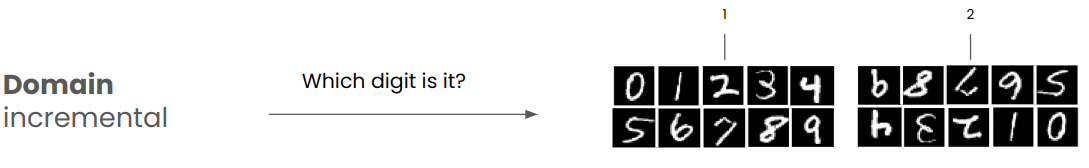

In [ ]:
# Setup
LEARNING_RATE = 0.001
TRAIN_EPOCHS = 1
DROP_RATE = 0.5
INPUT_LAYER_SIZE = 784
HIDDEN_LAYER_SIZE = 256
OUTPUT_LAYER_SIZE = 10
N_EXPERIENCES = 2
ROTATION_LIST = [60, 180]

def train_domain_incremental(method) -> list[dict[str, float]]:
    # Datasets
    mnist = ni_benchmark(
        mnist_train,
        mnist_test,
        n_experiences=len(ROTATION_LIST),
        shuffle=True,
        seed=SEED,
        balance_experiences=True,
    )
    mnist_train_stream = mnist.train_stream
    mnist_test_stream = mnist.test_stream
    
    rotated_mnist = RotatedMNIST(
        n_experiences=len(ROTATION_LIST),
        rotations_list=ROTATION_LIST,
        seed=SEED
    )
    rotated_mnist_train_stream = rotated_mnist.train_stream
    rotated_mnist_test_stream = rotated_mnist.test_stream

    # Train and test
    results_mnist, results_rotated_mnist = [], []

    # Train on MNIST and eval on both datasets
    for experience in mnist_train_stream:
        method.train(experience)
    
    results_mnist.append(method.eval(mnist_test_stream))
    results_rotated_mnist.append(method.eval(rotated_mnist_test_stream))

    # Train on RotatedMNIST and eval on both datasets
    for experience in rotated_mnist_train_stream:
        method.train(experience)
    
    results_mnist.append(method.eval(mnist_test_stream))
    results_rotated_mnist.append(method.eval(rotated_mnist_test_stream))

    return results_mnist, results_rotated_mnist


def plot_domain_incremental(results_mnist: list[dict[str, float]], results_rotated_mnist: list[dict[str, float]]) -> None:
    # Plot result
    acc_mnist_1 = results_mnist[0][TEST_ACCURACY] * 100
    acc_mnist_2 = results_mnist[1][TEST_ACCURACY] * 100
    acc_rot_mnist_1 = results_rotated_mnist[0][TEST_ACCURACY] * 100
    acc_rot_mnist_2 = results_rotated_mnist[1][TEST_ACCURACY] * 100
    df_data = pd.DataFrame({
        'Task (1 - training on MNIST, 2 - training on RotatedMNIST)': [1, 1, 2, 2],
        'Accuracy [%]': [acc_mnist_1, acc_rot_mnist_1, acc_mnist_2, acc_rot_mnist_2],
        'Dataset': ['MNIST', 'RotatedMNIST', 'MNIST', 'RotatedMNIST'],
    })
    
    sns.barplot(data=df_data, x='Task (1 - training on MNIST, 2 - training on RotatedMNIST)', y='Accuracy [%]', hue='Dataset')
    plt.show()
    
    avg_accuracy = (acc_mnist_2 + acc_rot_mnist_2) / 2
    print()
    print(f"\nFinal average accuracy: {avg_accuracy:.2f}%")

## Naive

Let's train with a standard, Naive approach and see what happens

In [ ]:
# Model
# To make experiments fair, remember to always initialize a new model and not to use already trained one.
model = MLP(input_layer_size=INPUT_LAYER_SIZE, hidden_layer_size=HIDDEN_LAYER_SIZE, output_layer_size=OUTPUT_LAYER_SIZE, drop_rate=DROP_RATE)

# Prepare for training & testing
optimizer = Adam(model.parameters(), lr=LEARNING_RATE)
criterion = CrossEntropyLoss()

# Joint training strategy
naive_train = Naive(
    model,
    optimizer,
    criterion,
    train_epochs=TRAIN_EPOCHS,
    train_mb_size=BATCH_SIZE_TRAIN,
    eval_mb_size=BATCH_SIZE_TEST,
    device=DEVICE,
    evaluator=NO_LOGGING_EVALUATOR,
)

results_mnist, results_rotated_mnist = train_domain_incremental(method=naive_train)
plot_domain_incremental(results_mnist, results_rotated_mnist)

MNIST has lost a lot of accuracy after training on the RotatedMNIST. This phenomenon is called a **Catastrophic Forgetting**.

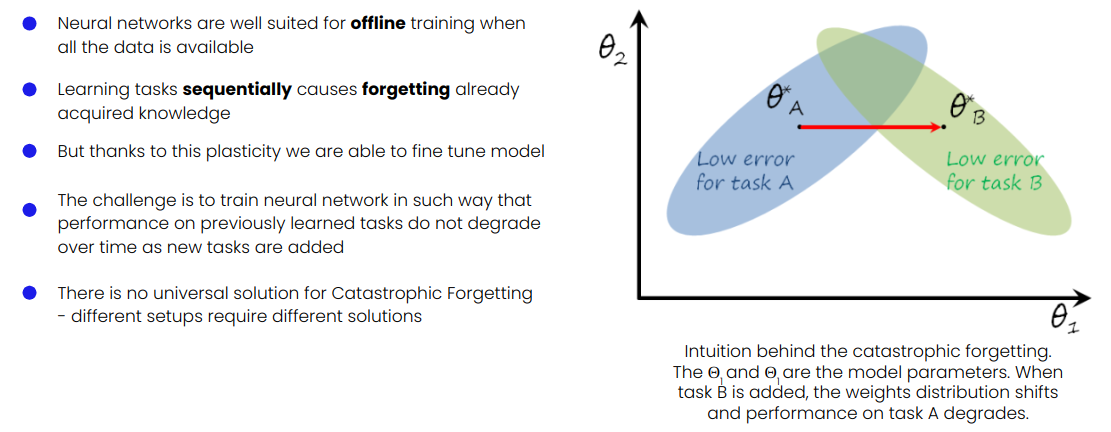

How can we prevent it?

## EWC

**E**lastic **W**eights **C**onsolidation is a regularization-based method inspired by advanced neuroscience memory consolidation theories.


**Idea**: limiting the learning of parameters critical to the performance of past tasks, as
measured by the Fisher Information Matrix.

**Intuition**: Update parameters in such way that it is minimally invasive for old tasks and allows to acquire new knowledge

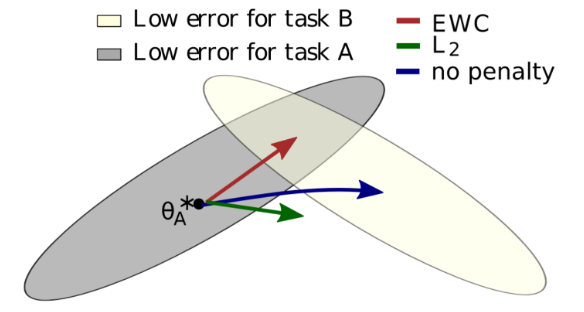 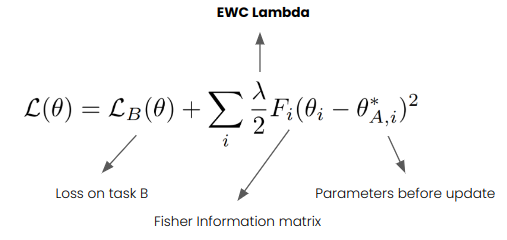

Kirkpatrick, James, et al. "Overcoming catastrophic forgetting in neural networks." Proceedings of the national academy of sciences 114.13 (2017): 3521-3526.

In [ ]:
# Setup
EWC_LAMBDA = 0.5

# Model
# To make experiments fair, remember to always initialize a new model and not to use already trained one.
model = MLP(input_layer_size=INPUT_LAYER_SIZE, hidden_layer_size=HIDDEN_LAYER_SIZE, output_layer_size=OUTPUT_LAYER_SIZE, drop_rate=DROP_RATE)

# Prepare for training & testing
optimizer = Adam(model.parameters(), lr=LEARNING_RATE)
criterion = CrossEntropyLoss()

# EWC training strategy
ewc = EWC(
    model,
    optimizer,
    criterion,
    train_epochs=TRAIN_EPOCHS,
    train_mb_size=BATCH_SIZE_TRAIN,
    eval_mb_size=BATCH_SIZE_TEST,
    device=DEVICE,
    evaluator=NO_LOGGING_EVALUATOR,
    # EWC hyperparameters
    ewc_lambda=EWC_LAMBDA,
)

results_mnist, results_rotated_mnist = train_domain_incremental(method=ewc)
plot_domain_incremental(results_mnist, results_rotated_mnist)

# GEM

**G**radien **E**pisodic **M**emory is a memory-based and regularization-based approach that tries to keep stable performance on already learned tasks. GEM solves a constrained optimization problem, gavoids increasing loss on old tasks. It projects the current task gradient in a feasible area, outlined by the previous task gradients and uses memory with random sampling. Thanks to this GEM's main target is to favour backward transfer and online learning capabilities.

**Idea**: constrain new task updates to not interfere with previous tasks.

**Intuition**: Update parameters in such way that it is minimally invasive for old tasks and allows to acquire new knowledge.

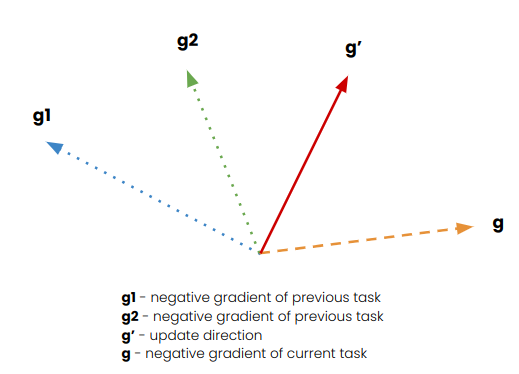

Lopez-Paz, David, and Marc'Aurelio Ranzato. "Gradient episodic memory for continual learning." Advances in neural information processing systems 30 (2017).

In [ ]:
# Setup
PATTERNS_PER_EXP = 200

# Model
# To make experiments fair, remember to always initialize a new model and not to use already trained one.
model = MLP(input_layer_size=INPUT_LAYER_SIZE, hidden_layer_size=HIDDEN_LAYER_SIZE, output_layer_size=OUTPUT_LAYER_SIZE, drop_rate=DROP_RATE)

# Prepare for training & testing
optimizer = Adam(model.parameters(), lr=LEARNING_RATE)
criterion = CrossEntropyLoss()

# GEM training strategy
gem = GEM(
    model,
    optimizer,
    criterion,
    train_epochs=TRAIN_EPOCHS,
    train_mb_size=BATCH_SIZE_TRAIN,
    eval_mb_size=BATCH_SIZE_TEST,
    device=DEVICE,
    evaluator=NO_LOGGING_EVALUATOR,
    # GEM hyperparameters
    patterns_per_exp=PATTERNS_PER_EXP,
)

results_mnist, results_rotated_mnist = train_domain_incremental(method=gem)
plot_domain_incremental(results_mnist, results_rotated_mnist)

***

## Exercise 2 (10 min)

Can you improve EWC method performance? Try to search for better **ewc_lambda**.

Tip: ewc_lambda is a hyperparameter controlling strength of regularization applied.

In [ ]:
EWC_LAMBDAS = [5, 1000]  # Fill this list with three/four different values to check ewc_lambda setups

accuracies = {}
for ewc_lambda in EWC_LAMBDAS:
    print(f"Training ewc_lambda={ewc_lambda}")
    
    # Model
    # To make experiments fair, remember to always initialize a new model and not to use already trained one.
    model = MLP(input_layer_size=INPUT_LAYER_SIZE, hidden_layer_size=HIDDEN_LAYER_SIZE, output_layer_size=OUTPUT_LAYER_SIZE, drop_rate=DROP_RATE)
    
    # Prepare for training & testing
    optimizer = Adam(model.parameters(), lr=LEARNING_RATE)
    criterion = CrossEntropyLoss()
    
    # EWC training strategy
    ewc = EWC(
        model,
        optimizer,
        criterion,
        train_epochs=TRAIN_EPOCHS,
        train_mb_size=BATCH_SIZE_TRAIN,
        eval_mb_size=BATCH_SIZE_TEST,
        device=DEVICE,
        evaluator=NO_LOGGING_EVALUATOR,
        # EWC hyperparameters
        ewc_lambda=ewc_lambda,
    )

    results_mnist, results_rotated_mnist = train_domain_incremental(method=ewc)
    accuracies[ewc_lambda] = {'MNIST accuracy': results_mnist[-1][TEST_ACCURACY], 'Rotated MNIST accuracy': results_rotated_mnist[-1][TEST_ACCURACY]}

In [ ]:
df_data = pd.DataFrame({'EWC Lambda': list(accuracies.keys()), 'Average Accuracy [%]': [sum(value.values()) / len(value) for value in accuracies.values()]})
sns.barplot(data=df_data, x='EWC Lambda', y='Average Accuracy [%]')

- What is the good choice for **ewc_lambda**?
- Can you explain why?
- How it affects the result?

***

# Class Incremental Continual Learning

This is the most difficult scenario in Continual Learning. We will work with the most challenging setup where each class is presented separately. So firstly the model see only the data labeled as 0, then 1, and so on...

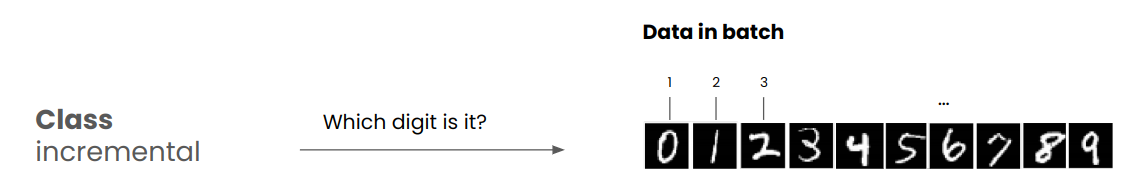

In [ ]:
# Setup
LEARNING_RATE = 0.001
TRAIN_EPOCHS = 1
DROP_RATE = 0.5
INPUT_LAYER_SIZE = 784
HIDDEN_LAYER_SIZE = 256
OUTPUT_LAYER_SIZE = 10
FIXED_CLASS_ORDER = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
N_EXPERIENCES = 10


def train_class_incremental(method) -> list[dict[str, float]]:
    # Dataset
    mnist = SplitMNIST(n_experiences=N_EXPERIENCES, fixed_class_order=FIXED_CLASS_ORDER)
    train_stream = mnist.train_stream
    test_stream = mnist.test_stream
    
    # Train and test
    results = []
    method.train(train_stream)
    evaluation_result = method.eval(test_stream)
    results.append(evaluation_result)
    
    return results

# Naive

In [ ]:
# Model.
# To make experiments fair, remember to always initialize a new model and not to use already trained one.
model = MLP(input_layer_size=INPUT_LAYER_SIZE, hidden_layer_size=HIDDEN_LAYER_SIZE, output_layer_size=OUTPUT_LAYER_SIZE, drop_rate=DROP_RATE)

# Prepare for training & testing
optimizer = Adam(model.parameters(), lr=LEARNING_RATE)
criterion = CrossEntropyLoss()

# Joint training strategy
joint_train = Naive(
    model,
    optimizer,
    criterion,
    train_epochs=TRAIN_EPOCHS,
    train_mb_size=BATCH_SIZE_TRAIN,
    eval_mb_size=BATCH_SIZE_TEST,
    device=DEVICE,
    evaluator=NO_LOGGING_EVALUATOR,
)

naive_results = train_class_incremental(method=joint_train)
print(f"Final test accuracy: {naive_results[-1][TEST_ACCURACY] * 100:.2f}%")

It's pretty bad Accuracy, isn't is? Final Accurracy looks like a random guessing.

This phenomenon is called a Recency Bias [SOURCE].

# EWC

In [ ]:
# Setup
EWC_LAMBDA = 0.5

# Model.
# To make experiments fair, remember to always initialize a new model and not to use already trained one.
model = MLP(input_layer_size=INPUT_LAYER_SIZE, hidden_layer_size=HIDDEN_LAYER_SIZE, output_layer_size=OUTPUT_LAYER_SIZE, drop_rate=DROP_RATE)

# Prepare for training & testing
optimizer = Adam(model.parameters(), lr=LEARNING_RATE)
criterion = CrossEntropyLoss()

# EWC training strategy
ewc = EWC(
    model,
    optimizer,
    criterion,
    train_epochs=TRAIN_EPOCHS,
    train_mb_size=BATCH_SIZE_TRAIN,
    eval_mb_size=BATCH_SIZE_TEST,
    device=DEVICE,
    evaluator=NO_LOGGING_EVALUATOR,
    # EWC hyperparameters
    ewc_lambda=EWC_LAMBDA,
)

ewc_results = train_class_incremental(method=ewc)
print(f"Final test accuracy: {ewc_results[-1][TEST_ACCURACY] * 100:.2f}%")

# GEM

In [ ]:
# Setup
PATTERNS_PER_EXP = 20

# Model.
# To make experiments fair, remember to always initialize a new model and not to use already trained one.
model = MLP(input_layer_size=INPUT_LAYER_SIZE, hidden_layer_size=HIDDEN_LAYER_SIZE, output_layer_size=OUTPUT_LAYER_SIZE, drop_rate=DROP_RATE)

# Prepare for training & testing
optimizer = Adam(model.parameters(), lr=LEARNING_RATE)
criterion = CrossEntropyLoss()

# GEM training strategy
gem = GEM(
    model,
    optimizer,
    criterion,
    train_epochs=TRAIN_EPOCHS,
    train_mb_size=BATCH_SIZE_TRAIN,
    eval_mb_size=BATCH_SIZE_TEST,
    device=DEVICE,
    evaluator=NO_LOGGING_EVALUATOR,
    # GEM hyperparameters
    patterns_per_exp=PATTERNS_PER_EXP,
)

gem_results = train_class_incremental(method=gem)
print(f"Final test accuracy: {gem_results[-1][TEST_ACCURACY] * 100:.2f}")

## Continual Learning Methods Comparison

Let's compare Naive, EWC and GEM methods.

In [ ]:
class_incremental_results = [naive_results, ewc_results, gem_results]
df_results = pd.DataFrame({
    'Method': ["Naive", "EWC (regularization)", "GEM (memory)"],
    'Accuracy [%]': [result[-1][TEST_ACCURACY] * 100 for result in class_incremental_results]
})
sns.barplot(data=df_results, x='Method', y='Accuracy [%]')

Memory-based method achieved the best performance and outperformed other methods by the significant margin. Why such thing happened? Class Incremental Continual Learning is the most difficult scenario and there is extremely hard to train a model when data from each class is presented separately. **Neural networks are overly plastic** and gradient-based optimization algorithms are handling such situation poorly.

The most common solution for Class Incremental Continual Learning problems is to keep some examples in the memory. It's very simple but brutally effective. Unfortunately, we not always have possibility to store examples in the memory. In lot of real-world applications data cannot be stored, e.g. due to RODO or privacy purposed or should be anonymyzed which makes it's useless for additional model training.

***

## Exercise 3 (10 min)

Compare GEM model performance with different memory buffer sizes. Try to determine what impact has memory buffer size on model accuracy. The more the better? Or there is other pattern? Fill the PATTERNS_PER_EXPERIENCE list below and run the cell.

In [ ]:
PATTERNS_PER_EXPERIENCE = [5, 10]  # Fill that list to try four/five different memory sizes and run the cell

evaluation_results = {}
for patterns_per_exp in PATTERNS_PER_EXPERIENCE:
    print(f"Training patterns_per_exp={patterns_per_exp}")
    
    # Model.
    # To make experiments fair, remember to always initialize a new model and not to use already trained one.
    model = MLP(input_layer_size=INPUT_LAYER_SIZE, hidden_layer_size=HIDDEN_LAYER_SIZE, output_layer_size=OUTPUT_LAYER_SIZE, drop_rate=DROP_RATE)
    
    # Prepare for training & testing
    optimizer = Adam(model.parameters(), lr=LEARNING_RATE)
    criterion = CrossEntropyLoss()
    
    # GEM training strategy
    gem = GEM(
        model,
        optimizer,
        criterion,
        train_epochs=TRAIN_EPOCHS,
        train_mb_size=BATCH_SIZE_TRAIN,
        eval_mb_size=BATCH_SIZE_TEST,
        device=DEVICE,
        evaluator=NO_LOGGING_EVALUATOR,
        # GEM hyperparameters
        patterns_per_exp=patterns_per_exp,
    )
    
    evaluation_result = train_class_incremental(method=gem)
    evaluation_results[patterns_per_exp] = evaluation_result

You can plot the results when experiments are finished. Just run the cell below. Remember that the hyperparameter that we experiment with is "patterns_per_exp". Experience = class in our case, so the total number of examples in the memory is number_of_classes times patterns_per_exp (10 * patterns_per_exp).

In [ ]:
memory_gem_results = [results[-1][TEST_ACCURACY] * 100 for key, results in evaluation_results.items()]
df_results = pd.DataFrame({'Memory size': [mem_size * 10 for mem_size in evaluation_results.keys()], 'Accuracy [%]': memory_gem_results})
sns.barplot(data=df_results, x='Memory size', y='Accuracy [%]')

- What was the best memory size? (memory size related to the highest accuracy)
- How memory size impact accuracy?
- What is a good trade-off between memory buffer size and accuracy? Can you find it?

***

## Exercise 4 (10 min)

We know that memory has a crucial role in Class Incremental Continual Learning, but we not always can store as many examples as we could. In this excercise your task is to determine the minimum number of examples needed to achieve accuracy >= 70%.

In [ ]:
MEMORY_SIZES = [10]  # Fill that list to try four/five different memory sizes and run the cell

evaluation_results = {}
for memory_size in MEMORY_SIZES:
    print(f"Train memory_size={memory_size}")
    
    model = MLP(input_layer_size=INPUT_LAYER_SIZE, hidden_layer_size=HIDDEN_LAYER_SIZE, output_layer_size=OUTPUT_LAYER_SIZE, drop_rate=DROP_RATE)
    optimizer = Adam(model.parameters(), lr=LEARNING_RATE)
    criterion = CrossEntropyLoss()
    replay = Replay(
        model,
        optimizer,
        criterion,
        mem_size=memory_size,
        train_epochs=TRAIN_EPOCHS,
        train_mb_size=BATCH_SIZE_TRAIN,
        eval_mb_size=BATCH_SIZE_TEST,
        device=DEVICE,
        evaluator=NO_LOGGING_EVALUATOR,
    )
    
    evaluation_result = train_class_incremental(method=replay)
    evaluation_results[memory_size] = evaluation_result

In [ ]:
all_results = [results[-1][TEST_ACCURACY] * 100 for key, results in evaluation_results.items()]
df_results = pd.DataFrame({'Memory size': [mem_size for mem_size in evaluation_results.keys()], 'Accuracy [%]': all_results})

if not df_results.empty:
    sns.barplot(data=df_results, x='Memory size', y='Accuracy [%]')

plt.axhline(70, linestyle='--', color='black')

- What memory size allows to achieve accuracy >= 70%?
- Is's a lot or a little?

***

# Final assingment

In this assingment your task will be to effectively train a model on MNIST and Permuted MNIST datasets. We already know something about the Continual Learning and it's scenarios and we will try to use this knowledge in practice, so don't hesitate to reuse a code from any place of this notebook. Preferably, the solution should:
- make changes in the model (may be architecture or just using different model. e.g. [SimpleCNN](https://avalanche.continualai.org/from-zero-to-hero-tutorial/02_models))
- use a new Continual Learning method... (see [methods](https://avalanche-api.continualai.org/en/v0.3.1/training.html#training-strategies))
- ... or use combination of already known methods (see [example](https://avalanche.continualai.org/from-zero-to-hero-tutorial/04_training#adding-plugins))
- add some new metric to evaluation (see [metrics](https://avalanche-api.continualai.org/en/v0.3.1/evaluation.html))
- have reasonable accuracy (at least > **90%** after training on both tasks)
- (optionally) perform HP search
- (optionally) experiment with a loss function, optimizer, number of epochs on each and other hyperparameters
- (optionally) what is the best result that you were able to achieve without a memory?

We had prepared a experimental template for you, so you can complete the assingment by filling the commented sections with your code. The purpose of this assingment is experiment with various settings and learn by trying (and failing). Write down your observations and conculsions.

Good luck!

In [ ]:
# Setup - try with your own
LEARNING_RATE = 0.001
TRAIN_EPOCHS = 1
DROP_RATE = 0.5
INPUT_LAYER_SIZE = 784
HIDDEN_LAYER_SIZE = 256
OUTPUT_LAYER_SIZE = 10
N_EXPERIENCES_MNIST = 2  # On how many data portions will be divided MNIST training
N_EXPERIENCES_PERMUTED_MNIST = 2  # On how many data portions will be divided PermutedMNIST training

In [ ]:
# --- Trainig & Evaluation code. Do not modify this function ---

def train_mnist_and_permuted_mnist(method) -> tuple[list[dict[str, float]], list[dict[str, float]]]:
    # Datasets
    mnist = ni_benchmark(
        mnist_train,
        mnist_test,
        n_experiences=N_EXPERIENCES_MNIST,
        shuffle=True,
        seed=SEED,
        balance_experiences=True,
    )
    mnist_train_stream = mnist.train_stream
    mnist_test_stream = mnist.test_stream
    
    permuted_mnist = PermutedMNIST(
        n_experiences=N_EXPERIENCES_PERMUTED_MNIST,
        seed=SEED,
    )
    permuted_mnist_train_stream = permuted_mnist.train_stream
    permuted_mnist_test_stream = permuted_mnist.test_stream
    
    # Train and test
    results_mnist, results_permuted_mnist = [], []
    
    # Train on MNIST and eval on both datasets
    method.train(mnist_train_stream)
    
    results_mnist.append(method.eval(mnist_test_stream))
    results_permuted_mnist.append(method.eval(permuted_mnist_test_stream))
    
    # Train on PermutedMNIST and eval on both datasets
    method.train(permuted_mnist_train_stream)
    
    results_mnist.append(method.eval(mnist_test_stream))
    results_permuted_mnist.append(method.eval(permuted_mnist_test_stream))

    return results_mnist, results_permuted_mnist

# --- Trainig & Evaluation code end ---

-- Your code starts here --

In [ ]:
from avalanche.models import SimpleCNN
from torch.optim import SGD

# Prepare your model
model = SimpleMLP()

# Prepare yout optimizer
optimizer = SGD(model.parameters(), lr=0.001, momentum=0.9)

# Prepare your loss function
criterion = CrossEntropyLoss()

In [ ]:
# Prepare your method

from avalanche.training import AGEM
from avalanche.training.templates import SupervisedTemplate
from avalanche.training.plugins import ReplayPlugin, EWCPlugin

replay = ReplayPlugin(mem_size=20)
ewc = EWCPlugin(ewc_lambda=0.001)

method = SupervisedTemplate(
    model,
    optimizer,
    criterion,
    plugins=[replay, ewc],
    device=DEVICE,
)

method = AGEM(
    model,
    optimizer,
    criterion,
    train_epochs=TRAIN_EPOCHS,
    train_mb_size=BATCH_SIZE_TRAIN,
    eval_mb_size=BATCH_SIZE_TEST,
    device=DEVICE,
    evaluator=DEFAULT_EVALUATOR,
    # GEM hyperparameters
    patterns_per_exp=10,
)

--- Your code ends here ---

In [ ]:
# Train & Evaluate

results_mnist, results_permuted_mnist = train_mnist_and_permuted_mnist(method=method)

In [ ]:
# Plot result

acc_mnist_1 = results_mnist[0][TEST_ACCURACY] * 100
acc_mnist_2 = results_mnist[1][TEST_ACCURACY] * 100
acc_perm_mnist_1 = results_permuted_mnist[0][TEST_ACCURACY] * 100
acc_perm_mnist_2 = results_permuted_mnist[1][TEST_ACCURACY] * 100
df_data = pd.DataFrame({
    'Task (1 - training on MNIST, 2 - training on PermutedMNIST)': [1, 1, 2, 2],
    'Accuracy [%]': [acc_mnist_1, acc_perm_mnist_1, acc_mnist_2, acc_perm_mnist_2],
    'Dataset': ['MNIST', 'PermutedMNIST', 'MNIST', 'PermutedMNIST'],
})

sns.barplot(data=df_data, x='Task (1 - training on MNIST, 2 - training on PermutedMNIST)', y='Accuracy [%]', hue='Dataset')
plt.axhline(90, linestyle='--', color='black')
plt.show()

avg_accuracy = (acc_mnist_2 + acc_perm_mnist_2) / 2
message = "great, you have accomplished the assingment!" if avg_accuracy >= 90 else "try to improve a litte bit."

print()
print(f"\nFinal average accuracy: {avg_accuracy:.2f}% - {message}")

***

# Further reading

- [Three scenarios for continual learning - obligatory lecture](https://arxiv.org/abs/1904.07734)
- [How architecture affects the Continual Learning performance?](https://arxiv.org/abs/2202.00275)
- [LFPT5 - Continual Learning approach for generative LLMs](https://arxiv.org/pdf/2110.07298.pdf)
- [S-Prompts - a solution for difficult problems where You cannot have a memory buffer](https://arxiv.org/pdf/2207.12819.pdf)
- [Survey for try-hards](https://arxiv.org/abs/2302.00487)
- [Avalanche site](https://avalanche.continualai.org/)
- [Avalanche Github](https://github.com/ContinualAI/avalanche)

# References

[1] De Lange, Matthias, et al. "A continual learning survey: Defying forgetting in classification tasks." IEEE transactions on pattern analysis and machine intelligence 44.7 (2021): 3366-3385.  
[2] Lomonaco, Vincenzo, et al. "Avalanche: an end-to-end library for continual learning." Proceedings of the IEEE/CVF Conference on Computer Vision and Pattern Recognition. 2021.  
[3] Kirkpatrick, James, et al. "Overcoming catastrophic forgetting in neural networks." Proceedings of the national academy of sciences 114.13 (2017): 3521-3526.  
[4] Lopez-Paz, David, and Marc'Aurelio Ranzato. "Gradient episodic memory for continual learning." Advances in neural information processing systems 30 (2017).